<a href="https://colab.research.google.com/github/Dhanraj7573/Python-Projects/blob/main/Credit_Risk_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Initial Shape: (39717, 7)
Cleaned Shape: (38577, 8)
Overall Default Rate: 14.59%

--- ANALYSIS 1: Risk vs Reward by Grade ---
      default_rate weighted_int_rate  total_volume
grade                                             
A            5.99%             7.37%   $86,575,425
B           12.21%            11.07%  $127,663,600
C           17.19%            13.57%   $84,728,775
D           21.99%            15.79%   $61,720,550
E           26.85%            17.83%   $41,756,150
F           32.68%            19.84%   $17,660,950
G           33.78%            21.42%    $6,055,650

--- ANALYSIS 2: Risk by Income Bracket ---
                  Avg_Loan_Size  Default_Rate
income_bin                                   
Low Income          6967.707259      0.180553
Medium Income       9846.329893      0.150349
High Income        12122.994845      0.140309
Very High Income   15285.677409      0.111911


/tmp/ipython-input-64235159.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_analysis = df.groupby('income_bin')[['loan_amnt', 'is_default']].agg({
/tmp/ipython-input-64235159.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grade_analysis.index, y=grade_analysis['default_rate']*100, palette='viridis')


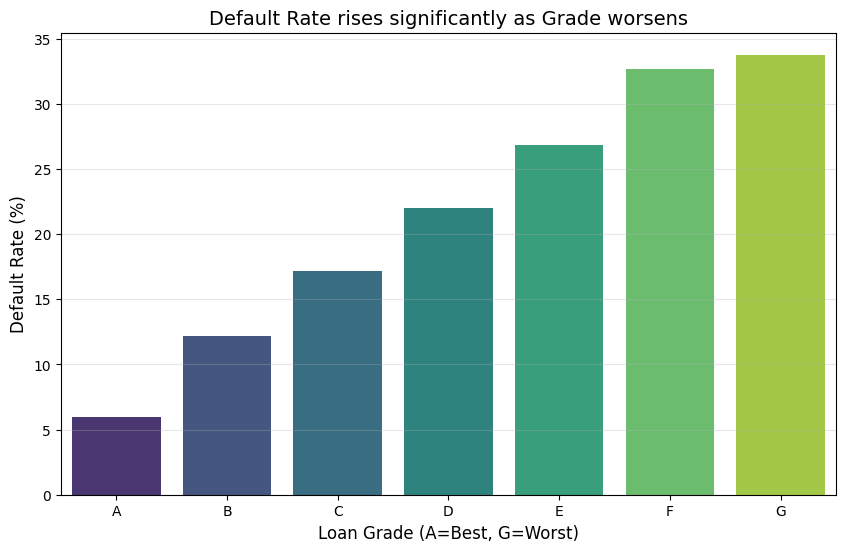


--- ANALYSIS 3: Vintage Analysis (Yearly Trends) ---
         loan_amnt is_default
year                         
2007    $2,219,275     17.93%
2008   $14,390,275     15.81%
2009   $46,436,325     12.60%
2010  $122,050,200     12.88%
2011  $241,065,025     15.87%


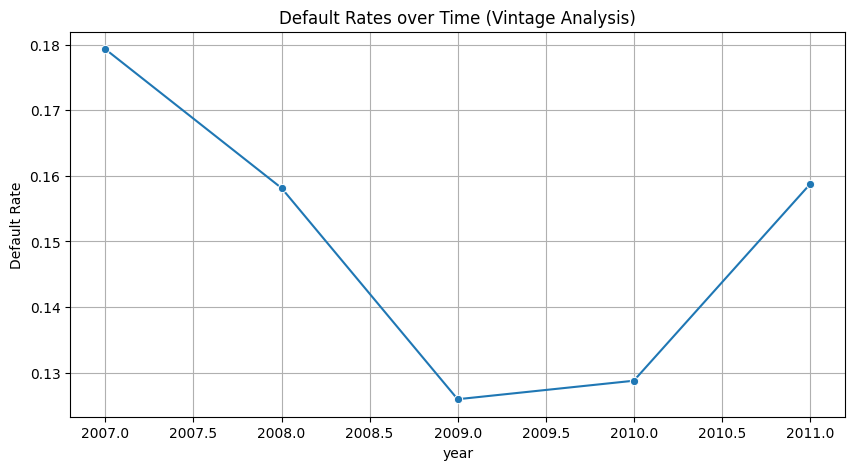

In [6]:

# PROJECT: Credit Risk Portfolio Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# LOAD DATA
print("Loading dataset...")
url = "https://raw.githubusercontent.com/akshayr89/Lending-Club---Exploratory-Data-Analysis/master/loan.csv"
df = pd.read_csv(url, low_memory=False)

# Select only relevant columns for Credit Analysis
cols_to_keep = ['loan_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'loan_status', 'issue_d']
df = df[cols_to_keep]

print(f"Initial Shape: {df.shape}")

# DATA CLEANING

# A. Clean Interest Rate (Remove '%' and convert to float)
if df['int_rate'].dtype == 'object':
    df['int_rate'] = df['int_rate'].str.strip('%').astype('float')

# B. Clean Term (Remove 'months' and whitespace)
if df['term'].dtype == 'object':
    df['term'] = df['term'].str.replace(' months', '').str.strip().astype(int)

# FEATURE ENGINEERING (Defining Risk)

# A. Define Target Variable: 1 = Default, 0 = Paid
# We filter out 'Current' loans because we don't know their fate yet.
target_statuses = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(target_statuses)].copy()

df['is_default'] = df['loan_status'].map({'Charged Off': 1, 'Fully Paid': 0})

# Clean Missing Values (Safe to do now that specific columns are fixed)
df.dropna(inplace=True)

print(f"Cleaned Shape: {df.shape}")
print(f"Overall Default Rate: {df['is_default'].mean():.2%}")

#  ANALYSIS I - RISK vs REWARD BY GRADE
# We calculate the Weighted Average Interest Rate (Volume-based)

# Create helper column for weighting
df['w_int'] = df['loan_amnt'] * df['int_rate']

# Groupby Logic
grade_analysis = df.groupby('grade').agg(
    total_volume=('loan_amnt', 'sum'),
    total_weighted_int=('w_int', 'sum'),
    default_rate=('is_default', 'mean')
)

# Calculate final Weighted Rate
grade_analysis['weighted_int_rate'] = grade_analysis['total_weighted_int'] / grade_analysis['total_volume']

# Clean up table for display
grade_summary = grade_analysis[['default_rate', 'weighted_int_rate', 'total_volume']].copy()
grade_summary['default_rate'] = grade_summary['default_rate'].map('{:.2%}'.format)
grade_summary['weighted_int_rate'] = grade_summary['weighted_int_rate'].map('{:.2f}%'.format)
grade_summary['total_volume'] = grade_summary['total_volume'].map('${:,.0f}'.format)

print("\n--- ANALYSIS 1: Risk vs Reward by Grade ---")
print(grade_summary)

# ANALYSIS II - INCOME SEGMENTATION
# Binning Income into 4 Quartiles (Low, Medium, High, Very High)

df['income_bin'] = pd.qcut(df['annual_inc'], q=4, labels=['Low Income', 'Medium Income', 'High Income', 'Very High Income'])

income_analysis = df.groupby('income_bin')[['loan_amnt', 'is_default']].agg({
    'loan_amnt': 'mean',
    'is_default': 'mean'
})

# Formatting
income_analysis.columns = ['Avg_Loan_Size', 'Default_Rate']
print("\n--- ANALYSIS 2: Risk by Income Bracket ---")
print(income_analysis)

# VISUALIZATION

plt.figure(figsize=(10, 6))
sns.barplot(x=grade_analysis.index, y=grade_analysis['default_rate']*100, palette='viridis')

plt.title('Default Rate rises significantly as Grade worsens', fontsize=14)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.xlabel('Loan Grade (A=Best, G=Worst)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\n--- ANALYSIS 3: Vintage Analysis (Yearly Trends) ---")

# 1. Convert 'issue_d' to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')

# 2. Extract Year
df['year'] = df['issue_d'].dt.year

# 3. Analyze Risk over Time
vintage_analysis = df.groupby('year')[['loan_amnt', 'is_default']].agg({
    'loan_amnt': 'sum',
    'is_default': 'mean'
})

# Format for display
vintage_display = vintage_analysis.copy()
vintage_display['is_default'] = vintage_display['is_default'].map('{:.2%}'.format)
vintage_display['loan_amnt'] = vintage_display['loan_amnt'].map('${:,.0f}'.format)

print(vintage_display)

# Optional: Plot the Trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=vintage_analysis, x=vintage_analysis.index, y='is_default', marker='o')
plt.title('Default Rates over Time (Vintage Analysis)')
plt.ylabel('Default Rate')
plt.grid(True)
plt.show()
